In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU ok')
else:
    print('GPU not ok, CPU')

GPU ok


In [2]:
import numpy as np
import random
import tensorflow as tf

SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import os

data_dir = "data"
male_dir = os.path.join(data_dir, "male")
female_dir = os.path.join(data_dir, "female")

male_files = [f for f in os.listdir(male_dir) if f.endswith(".wav")]
female_files = [f for f in os.listdir(female_dir) if f.endswith(".wav")]

print("Мужских записей:", len(male_files))
print("Женских записей:", len(female_files))
print("Всего:", len(male_files) + len(female_files))


Мужских записей: 10380
Женских записей: 5768
Всего: 16148


In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import entropy
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# Пути к папкам
data_dir = "data"
male_dir = os.path.join(data_dir, "male")
female_dir = os.path.join(data_dir, "female")


def extract_features(path_label):
    path, label = path_label
    y, sr = librosa.load(path, sr=None)

    S = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    mean_spec = S.mean(axis=1)

    mean_freq = np.average(freqs, weights=mean_spec)
    median_freq = np.quantile(freqs, 0.5)
    std_freq = np.sqrt(np.average((freqs - mean_freq) ** 2, weights=mean_spec))
    min_freq = freqs.min()
    max_freq = freqs.max()
    q25 = np.quantile(freqs, 0.25)
    q75 = np.quantile(freqs, 0.75)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

    mean_amp = np.mean(np.abs(y))
    std_amp = np.std(y)
    ps = np.abs(S) ** 2
    ps_norm = ps / ps.sum()
    spectral_entropy = entropy(ps_norm.flatten())

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)

    feats = {
        "file_name": os.path.basename(path),
        "mean_freq": mean_freq,
        "median_freq": median_freq,
        "std_freq": std_freq,
        "min_freq": min_freq,
        "max_freq": max_freq,
        "q25": q25,
        "q75": q75,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "mean_amp": mean_amp,
        "std_amp": std_amp,
        "spectral_entropy": spectral_entropy,
        "label": label
    }

    for i, coef in enumerate(mfccs_mean, 1):
        feats[f"mfcc_{i}"] = coef

    return feats


if __name__ == "__main__":
    file_list = [(os.path.join(male_dir, f), "male") for f in os.listdir(male_dir) if f.endswith(".wav")]
    file_list += [(os.path.join(female_dir, f), "female") for f in os.listdir(female_dir) if f.endswith(".wav")]

    rows = []
    max_workers = os.cpu_count()

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(extract_features, fl) for fl in file_list]

        for future in tqdm(as_completed(futures), total=len(futures), desc="Обработка файлов"):
            rows.append(future.result())

    df = pd.DataFrame(rows)
    df.to_pickle("features.pkl")


In [5]:
import pandas as pd

df = pd.read_pickle("features.pkl")

In [6]:
df.head()

,file_name,mean_freq,median_freq,std_freq,min_freq,max_freq,q25,q75,spectral_centroid,spectral_bandwidth,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,arctic_a0001(11).wav,1811.982969,4000.0,2104.752417,0.0,8000.0,2000.0,6000.0,1902.090293,1731.817868,...,32.394104,3.873539,0.509150,-16.400194,-10.607323,-5.334874,0.194010,-10.436570,5.331504,-8.698641
1,arctic_a0001(2).wav,1944.605943,4000.0,2040.336822,0.0,8000.0,2000.0,6000.0,2027.080025,1643.282423,...,27.882437,-9.652283,8.843859,-15.695701,-4.520260,-8.701425,2.879098,-10.710336,2.034143,-9.854539
2,arctic_a0001(8).wav,1585.063279,4000.0,1979.781333,0.0,8000.0,2000.0,6000.0,1800.290478,1711.054340,...,44.686924,6.212119,6.835624,-13.511187,-0.365110,-4.539759,-2.223957,-2.548868,-0.712892,-0.327769
3,arctic_a0001(10).wav,1685.122148,4000.0,1931.756249,0.0,8000.0,2000.0,6000.0,1737.764034,1610.350232,...,27.833303,-7.899630,8.501566,-5.758030,-12.511836,-12.819136,2.468086,-5.855250,3.040732,-9.723492
4,arctic_a0001(3).wav,2498.031309,4000.0,2183.703345,0.0,8000.0,2000.0,6000.0,2365.657581,1880.550930,...,43.396584,-6.145722,9.896058,-9.715407,11.901920,-10.572190,4.172913,-9.246496,6.153339,-5.553003


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = df.drop(["label", "file_name"], axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"train: {X_train_scaled.shape}, test: {X_test_scaled.shape}")
print(y_train_enc[:5])


train: (12918, 25), test: (3230, 25)
[1 1 0 1 0]


## логрег

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = model.fit(
    X_train_scaled, y_train_enc,
    validation_data=(X_test_scaled, y_test_enc),
    epochs=20,
    batch_size=64,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test_enc)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/20
202/202 [==============================] - 2s 4ms/step - loss: 0.2235 - accuracy: 0.9233 - val_loss: 0.1196 - val_accuracy: 0.9647
Epoch 2/20
202/202 [==============================] - 1s 3ms/step - loss: 0.1055 - accuracy: 0.9674 - val_loss: 0.0928 - val_accuracy: 0.9681
Epoch 3/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0889 - accuracy: 0.9699 - val_loss: 0.0829 - val_accuracy: 0.9672
Epoch 4/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0823 - accuracy: 0.9709 - val_loss: 0.0789 - val_accuracy: 0.9690
Epoch 5/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0785 - accuracy: 0.9708 - val_loss: 0.0761 - val_accuracy: 0.9709
Epoch 6/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0764 - accuracy: 0.9712 - val_loss: 0.0738 - val_accuracy: 0.9709
Epoch 7/20
202/202 [==============================] - 1s 3ms/step - loss: 0.0748 - accuracy: 0.9714 - val_loss: 0.0757 - val_accuracy: 0.9703
Epoch 

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred)
rec = recall_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


101/101 [==============================] - 0s 1ms/step
Accuracy: 0.9724
Precision: 0.9779
Recall: 0.9793
F1-score: 0.9786


## рандомфорест

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_enc)

y_pred_rf = rf_model.predict(X_test_scaled)

In [12]:
acc_rf = accuracy_score(y_test_enc, y_pred_rf)
prec_rf = precision_score(y_test_enc, y_pred_rf)
rec_rf = recall_score(y_test_enc, y_pred_rf)
f1_rf = f1_score(y_test_enc, y_pred_rf)

print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

Accuracy: 0.9910
Precision: 0.9918
Recall: 0.9942
F1-score: 0.9930


## сравнение

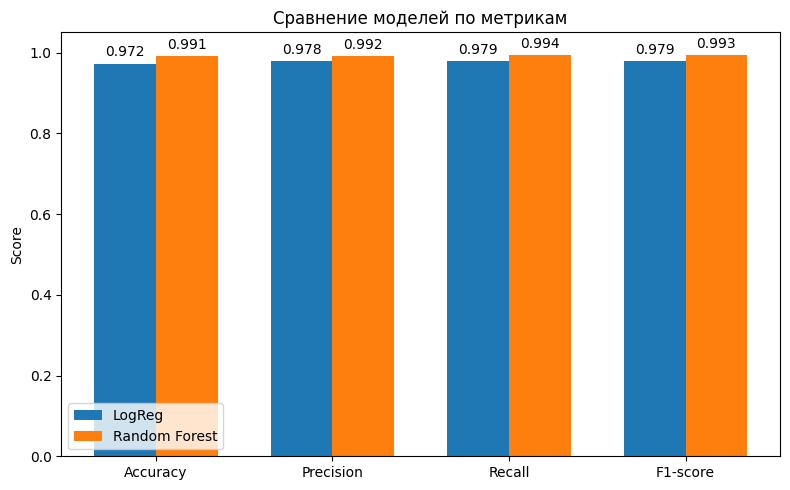

In [13]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
logreg_scores = [acc, prec, rec, f1]
rf_scores = [acc_rf, prec_rf, rec_rf, f1_rf]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, logreg_scores, width, label="LogReg")
rects2 = ax.bar(x + width/2, rf_scores, width, label="Random Forest")

ax.set_ylabel("Score")
ax.set_title("Сравнение моделей по метрикам")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


## важность признаков

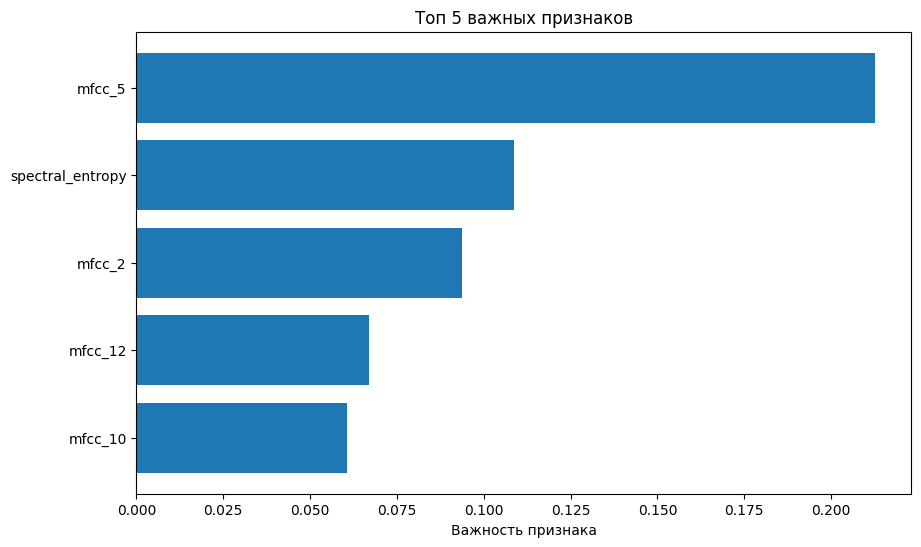

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

importances = rf_model.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_n = 5
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"].head(top_n)[::-1], feat_imp["importance"].head(top_n)[::-1])
plt.xlabel("Важность признака")
plt.title(f"Топ {top_n} важных признаков")
plt.show()


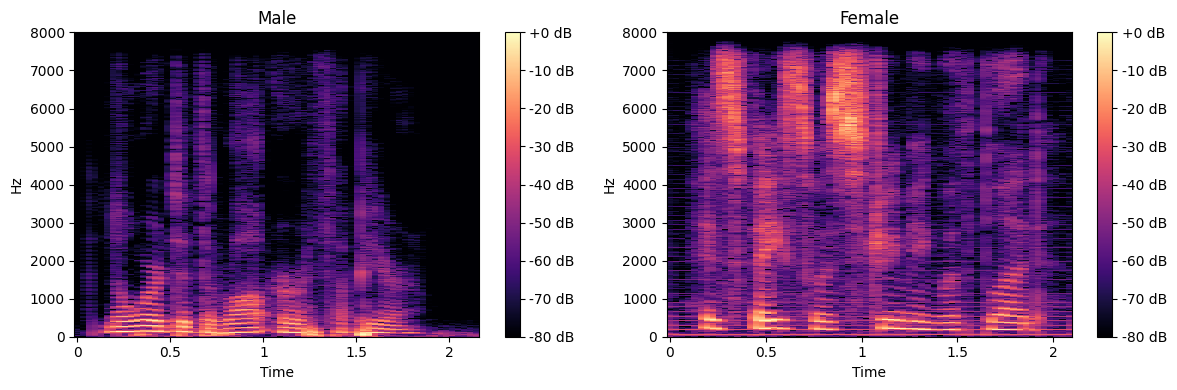

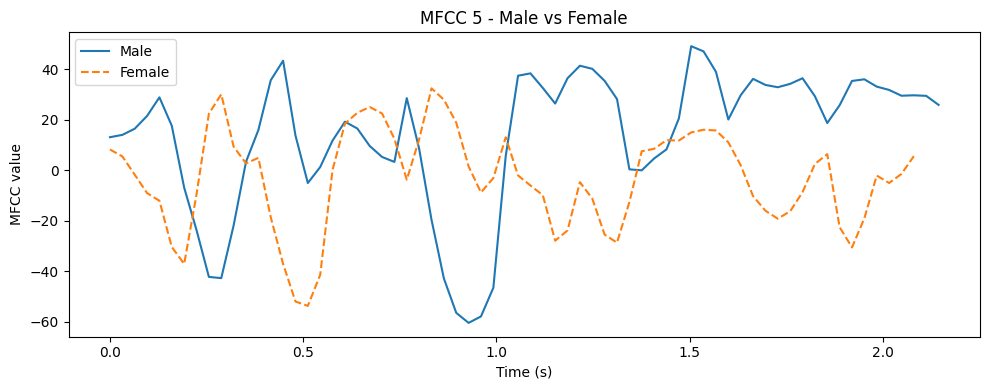

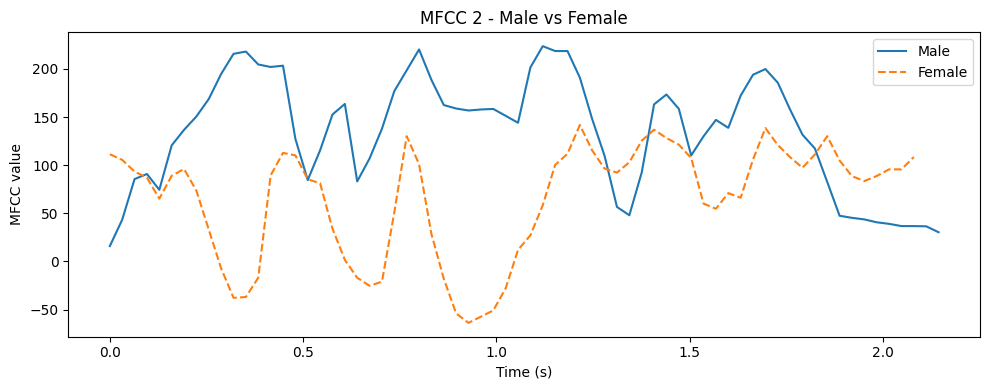

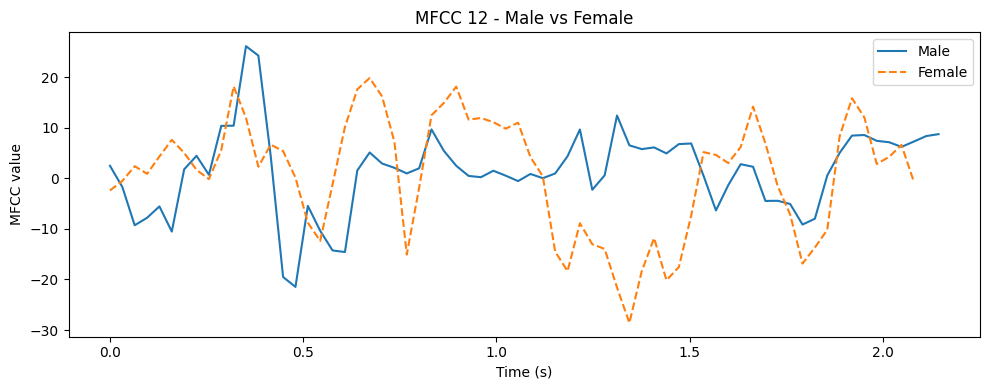

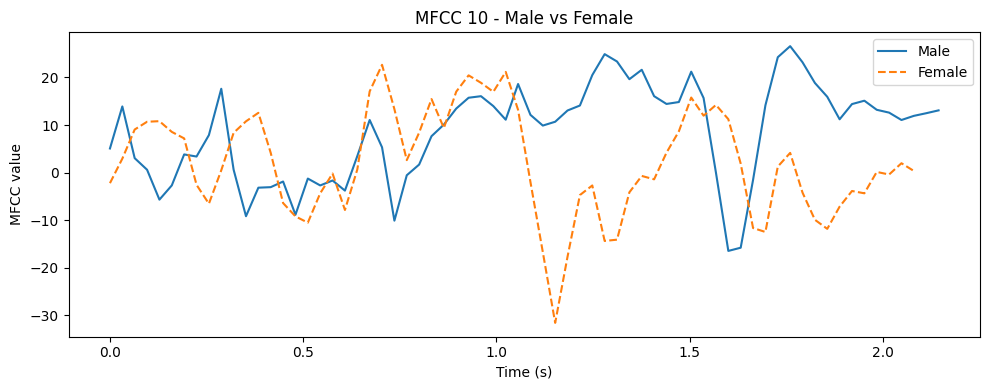

In [15]:
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

male_example = df[df["label"]=="male"].sort_values("mean_freq", ascending=True).iloc[0]
female_example = df[df["label"]=="female"].sort_values("mean_freq", ascending=False).iloc[0]

male_file = os.path.join(male_dir, male_example["file_name"])
female_file = os.path.join(female_dir, female_example["file_name"])

files = [male_file, female_file]
titles = ["Male", "Female"]

plt.figure(figsize=(12,4))
for i, file in enumerate(files, 1):
    y, sr = librosa.load(file, sr=None)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.subplot(1, 2, i)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(titles[i-1])

plt.tight_layout()
plt.show()

coeffs = [4, 1, 11, 9]  # MFCC 2, 5, 12 (нумерация с 0)
labels = ["MFCC 5", "MFCC 2", "MFCC 12", "MFCC 10"]

y_m, sr_m = librosa.load(male_file, sr=None)
y_f, sr_f = librosa.load(female_file, sr=None)

mfcc_m = librosa.feature.mfcc(y=y_m, sr=sr_m, n_mfcc=13)
mfcc_f = librosa.feature.mfcc(y=y_f, sr=sr_f, n_mfcc=13)

time_m = np.arange(mfcc_m.shape[1]) * (512 / sr_m)
time_f = np.arange(mfcc_f.shape[1]) * (512 / sr_f)

for i, c in enumerate(coeffs):
    plt.figure(figsize=(10,4))
    plt.plot(time_m, mfcc_m[c], linestyle='-', label="Male")
    plt.plot(time_f, mfcc_f[c], linestyle='--', label="Female")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC value")
    plt.title(f"{labels[i]} - Male vs Female")
    plt.legend()
    plt.tight_layout()
    plt.show()


- **MFCC 5**
  общая форма речи

- **Спектральная энтропия**
  "хаотичность" сигнала, насколько звук скачет

- **MFCC 2**
  низкие частоты

- **MFCC 12**
  высокие частоты

- **MFCC 10**
  средние частоты
